# Comparison To Gaussian Orbitals


In this notebook, we will compare a calculation using the BigDFT code which is based on wavelets to a calculation from a code which is based on Gaussian orbitals. As our representative Gaussian code, we will use [PySCF](https://sunqm.github.io/pyscf/), which we need to install alongside the usual setup.

In [ ]:
! pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
! conda install -c "conda-forge/label/bigdft_dev" bigdft-suite  > /dev/null  2> /dev/null

In [ ]:
! pip install PyBigDFT  > /dev/null  2> /dev/null
! pip install py3dmol  > /dev/null  2> /dev/null

In [1]:
! pip install -q pyscf > /dev/null 2> /dev/null

To do the comparison, we are going to look at a molecule composed of two fragments connected by a single bond. We will then rotate one fragment along that bond, computing the energy at each step. We will do this calculation using different basis sets, and see how the energy values converge and compare.

First, we will load in the system.

In [2]:
from BigDFT.IO import XYZReader
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment

geom = "CH3SH"

sys = System()
sys["FRA:0"] = Fragment()
sys["FRA:1"] = Fragment()

with XYZReader(geom) as ifile:
    for i, at in enumerate(ifile):
        if i == 0 or i == 3 or i == 4 or i == 5:
            sys["FRA:0"] += Fragment([at])
        else:
            sys["FRA:1"] += Fragment([at])

We can visualize the molecule to verify that we have properly broken it into two fragments.

In [3]:
_ = sys.display()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We want to rotate along the bond connecting the two fragments. To do this we need to compute that vector to rotate on.

In [4]:
vec = [x - y for x, y in 
       zip(sys["FRA:0"][0].get_position(), sys["FRA:1"][0].get_position())]

Now we can take several angles up to 60 degrees.

In [5]:
from copy import deepcopy

systems = []
angles = []
steps = 4
max_theta = 60

for i in range(steps):
    newsys = deepcopy(sys)
    newsys["FRA:0"].rotate_on_axis(angle=max_theta/(steps-1) * i, 
                                   axis=vec, units="degrees")
    systems.append(newsys)
    angles += [max_theta/(steps-1) * i]

## PySCF Calcuations
Now let's calculate the energy of this system using the PySCF code at the Hartree-Fock level of theory. Hartree-Fock is more convenient than DFT because we do not have to consider the integration grid used for the exchange and correlation potential. We will repeat this calculation using various Karlsruhe basis sets.

In [6]:
basis = ["sto-3g", "def2-SVP", "def2-TZVP"]

We need a simple routine to convert to the pyscf format.

In [7]:
def convert_bigdft_to_pyscf(sys, basis, verbose = 0):
    from pyscf import gto
    mol = gto.Mole()
    for frag in sys.values():
        for at in frag:
            mol.atom.append([at.sym, at.get_position("angstroem")])
    mol.basis = basis
    mol.verbose = verbose
    mol.build()
    return mol

Run and extract energy and forces.

In [8]:
from pyscf.scf import HF
from numpy.linalg import norm

pyscf_forces = {}
pyscf_energies = {}

for b in basis:
    pyscf_energies[b] = []
    pyscf_forces[b] = []
    for sys in systems:
        m = convert_bigdft_to_pyscf(sys, b)
        
        mf = HF(m)
        pyscf_energies[b].append(mf.kernel())
        
        g = mf.nuc_grad_method()
        grad = g.kernel()
        pyscf_forces[b].append(grad.tolist())

With the calculations completed, we can now plot the values. We'll look at how the energy changes from the starting configuration, and compute the norm of the difference in forces.

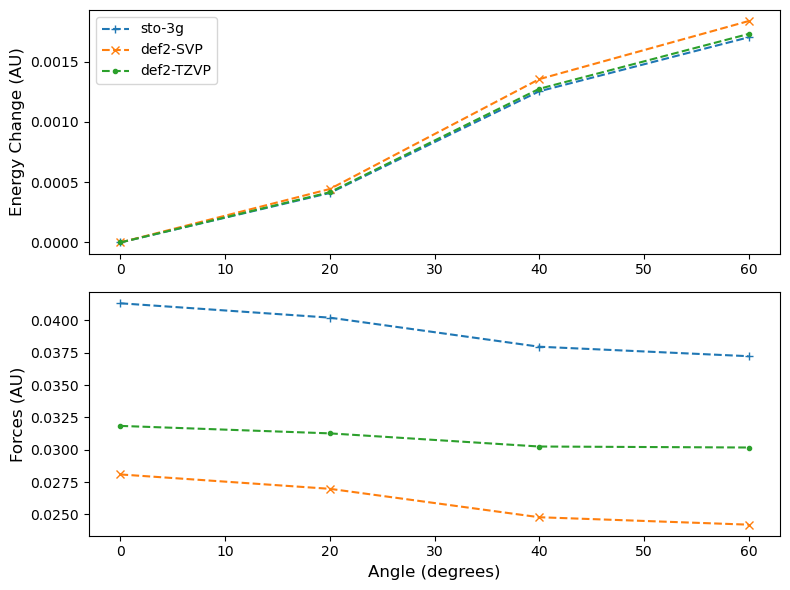

In [9]:
from matplotlib import pyplot as plt
from numpy.linalg import norm
from numpy import array

fig, axs = plt.subplots(2,1,figsize=(8,6))

markers = ["+", "x", ".", "o"]
for m, b in zip(markers, basis):
    axs[0].plot(angles, [(x - pyscf_energies[b][0]) for x in pyscf_energies[b]], 
                label=b, marker=m, linestyle='--')
    axs[1].plot(angles, [norm(x) for x in pyscf_forces[b]], 
                label=b, marker=m, linestyle='--')
    
axs[0].set_ylabel("Energy Change (AU)", fontsize=12)
axs[1].set_ylabel("Forces (AU)", fontsize=12)
axs[1].set_xlabel("Angle (degrees)", fontsize=12)
    
axs[0].legend()
fig.tight_layout()

We see that the energy does seem to successfully converge. We also see a good part about Gaussian basis functions: even with the small basis, the values are qualitatively correct. On the other hand, we see a weakness of this approach, where the smaller basis set (STO-3G) performs better than a bigger one (def2-SVP). Care must be taken to determine if a large enough basis was used.

## BigDFT Calculations

We will now repeat this calculation using BigDFT. For simplicity we will only vary the grid spacing, and leave the rmults fixed.

In [10]:
hgrid = [0.6, 0.5, 0.4]

In [11]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_xc("HF")
inp.set_rmult([4.0, 6.0])
# The multipole preserving feature can improve accuracy for loose grids
inp.setdefault('perf',{}).update({'multipole_preserving':True})
# Use NLCC pseudopotentials
inp.set_psp_nlcc()
# There is no NLCC available in our database for Sulphur, so we will have to use HGH-LDA
inp['psppar.S']={'Pseudopotential XC': 11}

Now we repeat the calculation for each grid spacing, which will take several minutes - it is for this reason that we avoid using too small a hgrid.

In [12]:
from BigDFT.Calculators import SystemCalculator

code = SystemCalculator(verbose=False, skip=True)

bigdft_energies = {}
bigdft_forces = {}
for h in hgrid:
    inp.set_hgrid(h)
    bigdft_energies[h] = []
    bigdft_forces[h] = []
    print('Running with h =',h)
    for i, m in enumerate(systems):
        log = code.run(input=inp, posinp=m.get_posinp(), 
                       name=str(h) + "-" + str(i), run_dir="scr")

        m.set_atom_forces(log)
        bigdft_energies[h].append(log.energy)
        
        forces = []
        for frag in m.values():
            for at in frag:
                forces.append(at.get_force())
        bigdft_forces[h].append(array(forces))

Running with h = 0.6
Running with h = 0.5
Running with h = 0.4


And we can plot the results.

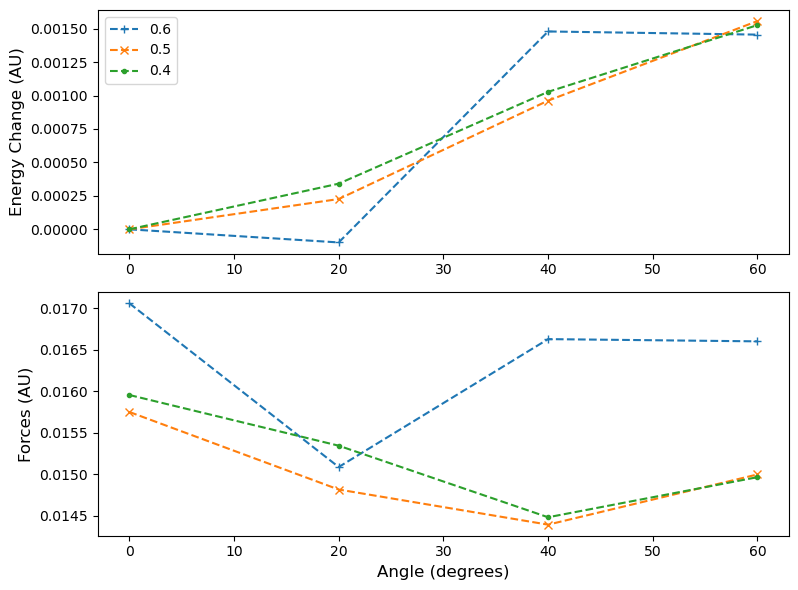

In [13]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,1,figsize=(8,6))

markers = ["+", "x", ".", "o"]
for m, b in zip(markers, hgrid):
    axs[0].plot(angles, 
                [(x - bigdft_energies[b][0]) for x in bigdft_energies[b]], 
                label=b, marker=m, linestyle='--')
    axs[1].plot(angles, [norm(x) for x in bigdft_forces[b]], 
                label=b, marker=m, linestyle='--')
    
axs[0].set_ylabel("Energy Change (AU)", fontsize=12)
axs[1].set_ylabel("Forces (AU)", fontsize=12)
axs[1].set_xlabel("Angle (degrees)", fontsize=12)
    
axs[0].legend()
fig.tight_layout()

The energy improves systematically with the choice of hgrid due to the variational formalism applied, which becomes more visible if a wider range of hgrids are tested. We also see that a loose cutoff can lead to disastrous results. In the case of Gaussian basis sets, a small basis might be qualitatively right since it was fitted to similar types of systems. But a numerical basis is more "all or nothing".

We can also plot the best energy values of the two codes on the same axis.

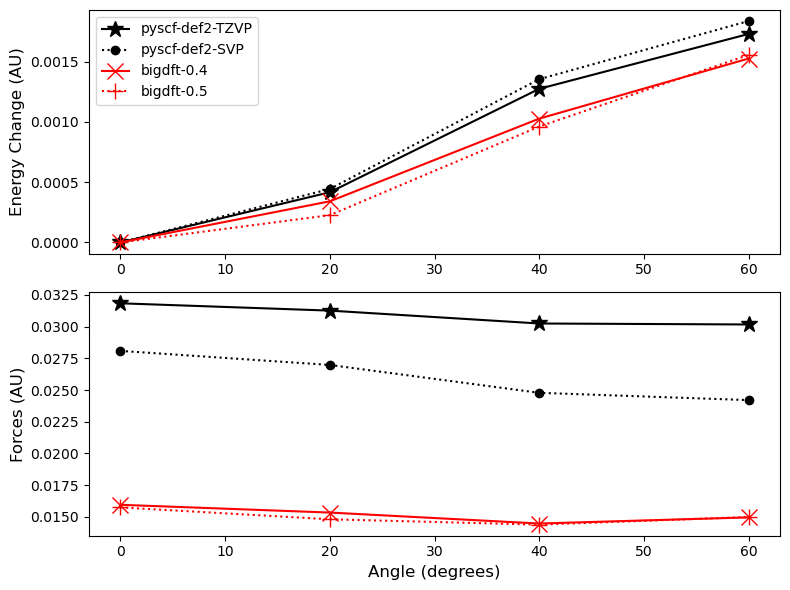

In [14]:
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(angles, 
            [(x - pyscf_energies[basis[-1]][0]) 
             for x in pyscf_energies[basis[-1]]],
            label="pyscf-" + str(basis[-1]), color='k', marker='*', 
            linestyle='-', markersize=12)
axs[0].plot(angles, 
            [(x - pyscf_energies[basis[-2]][0]) 
             for x in pyscf_energies[basis[-2]]],
            label="pyscf-" + str(basis[-2]), color='k', marker='.', 
            linestyle='dotted', markersize=12)
axs[0].plot(angles, 
            [(x - bigdft_energies[hgrid[-1]][0]) 
             for x in bigdft_energies[hgrid[-1]]],
            label="bigdft-" + str(hgrid[-1]), color='r', marker='x', 
            linestyle='-', markersize=12)
axs[0].plot(angles, 
            [(x - bigdft_energies[hgrid[-2]][0]) 
             for x in bigdft_energies[hgrid[-2]]],
            label="bigdft-" + str(hgrid[-2]), color='r', marker='+', 
            linestyle='dotted', markersize=12)

axs[1].plot(angles, [norm(x) for x in pyscf_forces[basis[-1]]],
            label="pyscf-" + str(basis[-1]), color='k', marker='*', 
            linestyle='-', markersize=12)
axs[1].plot(angles, [norm(x) for x in pyscf_forces[basis[-2]]],
            label="pyscf-" + str(basis[-2]), color='k', 
            marker='.', linestyle='dotted', markersize=12)
axs[1].plot(angles, [norm(x) for x in bigdft_forces[hgrid[-1]]],
            label="bigdft-" + str(hgrid[-1]), color='r', marker='x', 
            linestyle='-', markersize=12)
axs[1].plot(angles, [norm(x) for x in bigdft_forces[hgrid[-2]]],
            label="bigdft-" + str(hgrid[-2]), color='r', 
            marker='+', linestyle='dotted', markersize=12)
    
axs[0].set_ylabel("Energy Change (AU)", fontsize=12)
axs[1].set_ylabel("Forces (AU)", fontsize=12)
axs[1].set_xlabel("Angle (degrees)", fontsize=12)
    
axs[0].legend()
fig.tight_layout()

### Exercise

How would you use the concepts in this tutorial to compare the convergence behaviour of BigDFT and CASTEP or CRYSTAL?